# 1. Setup and Get Data

## 1.1 Install dependencies

In [1]:
%pip install labelme tensorflow-macos tensorflow-metal opencv-python matplotlib albumentations

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGE_PATH = os.path.join('data', 'images')
number_of_images = 30

In [5]:
cap = cv2.VideoCapture(1)
for imagenum in range(number_of_images):
    print ('Collecting image {}'.format(imagenum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

2024-10-18 01:07:06.038 Python[18996:39627247] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


: 

## Install LabelMe

In [3]:
!labelme

Traceback (most recent call last):
  File "/opt/homebrew/bin/labelme", line 5, in <module>
    from labelme.__main__ import main
  File "/opt/homebrew/lib/python3.11/site-packages/labelme/__init__.py", line 6, in <module>
    from qtpy import QT_VERSION
  File "/opt/homebrew/lib/python3.11/site-packages/qtpy/__init__.py", line 287, in <module>
    raise QtBindingsNotFoundError from None
qtpy.QtBindingsNotFoundError: No Qt bindings could be found


# 2. Review Dataset and Build the image loading function

In [4]:
import sys

print(sys.executable)

/Applications/Xcode.app/Contents/Developer/usr/bin/python3


## 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

/Users/akhilchawathe/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Limit GPU Memory Growth

In [10]:
# prevent out of memory issues
gpus = tf.config.experimental.list_physical_devices('GPU')

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load images into TF Data pipeline

In [12]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [13]:
# verify that image paths are correct
images.as_numpy_iterator().next()

b'data/images/d2c3ffbe-8d0e-11ef-a3c0-82e226126e03.jpg'

In [14]:
def load_image(image_path):
    byte_image = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [17]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## View the raw images with MatPlotLib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

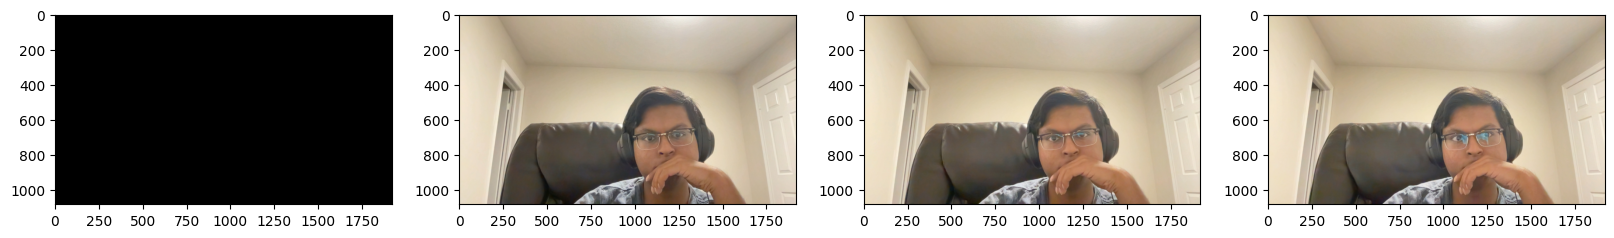

In [20]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(plot_images):
    axs[idx].imshow(img)
plt.show()

# Partitioning Unaugmented Data

## Manually split the data

In [47]:
117*0.7 #82 images for training

81.89999999999999

In [48]:
117*.15 #18 images for test and 17 to validate

17.55

## Move Matching Labels

In [51]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# Apply augmentation to data via Albumentations

## set up albumentations

In [27]:
import albumentations as alb

In [28]:
augmentor = alb.Compose([
    alb.RandomCrop(width=960, height=960), 
    alb.RandomBrightnessContrast(p=0.2), 
    alb.RandomGamma(p=0.2), 
    alb.VerticalFlip(p=0.5), 
    alb.HorizontalFlip(p=0.5),  
    alb.RGBShift(p=0.2), 
    alb.RandomRotate90(p=0.5), 
    alb.RandomSunFlare(p=0.2), 
    alb.RandomFog(p=0.2), 
    alb.RandomRain(p=0.2), 
    alb.RandomSnow(p=0.2), 
    alb.RandomShadow(p=0.2), 
    alb.RandomToneCurve()  
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## Load a test image

In [21]:
img = cv2.imread(os.path.join('data', 'train', 'images', 'd0321cac-8b44-11ef-8442-82e226126e03.jpg'))

In [22]:
with open(os.path.join('data', 'train', 'labels', 'd0321cac-8b44-11ef-8442-82e226126e03.json')) as f:
    label = json.load(f)

## Extract Coordinates and Rescale to Match the image resolution

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [24]:
coords = list(np.divide(coords, [1920, 1080, 1920, 1080]))

In [25]:
coords

[0.453125, 0.2920227920227921, 0.7544070512820512, 0.9814814814814815]

## Apply augmentation

In [29]:
augmented = augmentor(image=img, bboxes = [coords], class_labels=['face'])

In [30]:
augmented['image']

array([[[171, 195, 205],
        [171, 195, 205],
        [171, 195, 205],
        ...,
        [139, 164, 180],
        [139, 164, 180],
        [138, 163, 179]],

       [[170, 196, 206],
        [170, 196, 206],
        [170, 196, 206],
        ...,
        [142, 166, 178],
        [139, 166, 178],
        [138, 164, 177]],

       [[170, 196, 206],
        [170, 196, 206],
        [170, 196, 206],
        ...,
        [142, 166, 178],
        [138, 164, 177],
        [138, 164, 177]],

       ...,

       [[180, 183, 192],
        [181, 185, 196],
        [181, 185, 196],
        ...,
        [109,  96,  93],
        [113,  98,  94],
        [109,  96,  93]],

       [[180, 183, 192],
        [180, 183, 192],
        [180, 183, 192],
        ...,
        [113,  98,  94],
        [113,  98,  94],
        [113,  98,  94]],

       [[172, 180, 189],
        [172, 180, 189],
        [172, 180, 189],
        ...,
        [113,  98,  94],
        [113,  98,  94],
        [113,  98,  94]]

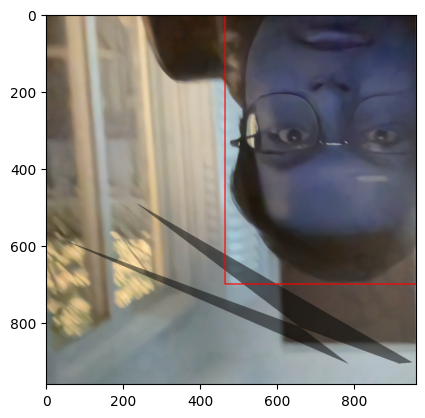

In [170]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [960, 960]).astype(int)), 
              tuple(np.multiply(augmented['bboxes'][0][2:], [960, 960]).astype(int)), 
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

## Build and Run Augmentation Pipeline

In [33]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

/Users/akhilchawathe/Library/Python/3.9/lib/python/site-packages/albumentations/core/bbox_utils.py:476: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


## Load Augmented images into tensorflow dataset

In [31]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [32]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [33]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.7637255 , 0.7794118 , 0.7127451 ],
        [0.75490195, 0.7745098 , 0.6960784 ],
        [0.777451  , 0.7892157 , 0.7147059 ],
        ...,
        [0.7470588 , 0.77254903, 0.6519608 ],
        [0.74313724, 0.7627451 , 0.6431373 ],
        [0.74607843, 0.7656863 , 0.6480392 ]],

       [[0.76960784, 0.7892157 , 0.7107843 ],
        [0.7529412 , 0.77254903, 0.69411767],
        [0.777451  , 0.7892157 , 0.7147059 ],
        ...,
        [0.7509804 , 0.76666665, 0.6647059 ],
        [0.7470588 , 0.7627451 , 0.65686274],
        [0.7392157 , 0.75784314, 0.6431373 ]],

       [[0.7627451 , 0.78137255, 0.7058824 ],
        [0.7627451 , 0.77843136, 0.7117647 ],
        [0.7764706 , 0.7882353 , 0.7176471 ],
        ...,
        [0.7745098 , 0.7823529 , 0.6882353 ],
        [0.76862746, 0.78431374, 0.68235296],
        [0.75980395, 0.7764706 , 0.66764706]],

       ...,

       [[0.44117647, 0.37254903, 0.3137255 ],
        [0.4715686 , 0.40490195, 0.3480392 ],
        [0.5127451 , 0

# Prepare Labels

## Build Label loading function

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    
    return [label['class'], label['bbox']]

## Load into TF dataset

In [36]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# Combine Label and Image Samples

## Check partition lengths

In [39]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4920, 4920, 1080, 1080, 1020, 1020)

## Create Final Dataset

In [40]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [41]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [42]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

## View Images and Annotations

In [43]:
data_samples = train.as_numpy_iterator()

In [44]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


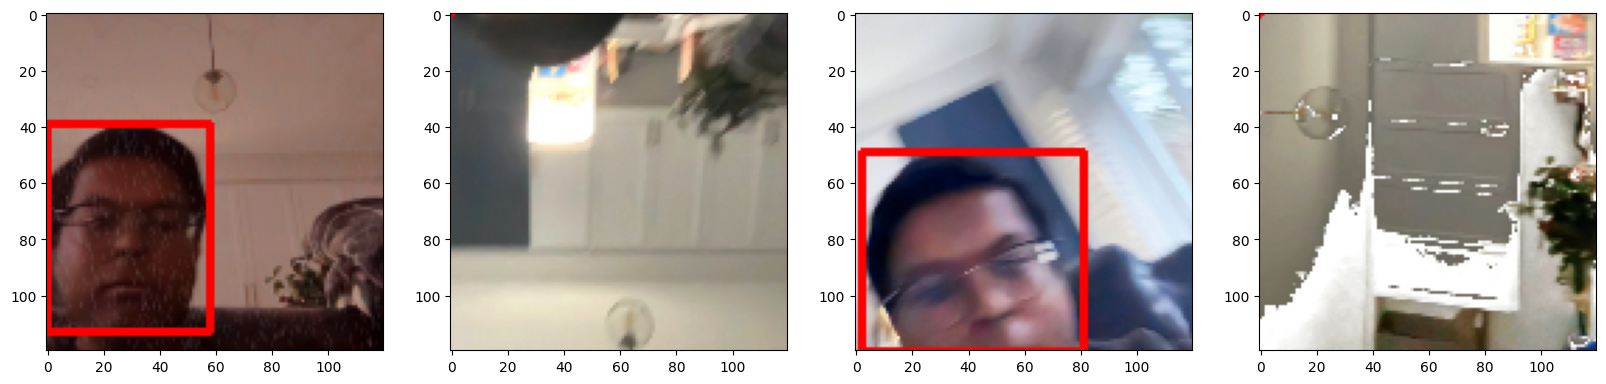

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = np.copy(res[0][idx])
    sample_label = np.copy(res[1][1][idx])
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_label[:2], [120, 120]).astype(int)), 
                  tuple(np.multiply(sample_label[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)
    
    ax[idx].imshow(sample_image)

# Build and Train Deep Learning Model

## Import Layers and Base Network

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## Download VGG16

In [47]:
vgg  = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

In [48]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 120, 120, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 120, 120, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Build the Neural Net

In [49]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

    

## Test the Neural Net Out

In [50]:
facetracker = build_model()

In [51]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
X, y = train.as_numpy_iterator().next()


In [53]:
y

(array([1, 1, 0, 0, 1, 0, 0, 1], dtype=uint8),
 array([[0.4983 , 0.1628 , 1.     , 0.9272 ],
        [0.1715 , 0.5864 , 0.811  , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.4753 , 0.04077, 1.     , 0.773  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2563 , 0.873  , 0.8174 , 1.     ]], dtype=float16))

In [54]:
classes, coords = facetracker.predict(X)

2024-10-21 19:30:17.819125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


In [55]:
classes, coords

(array([[0.35329416],
        [0.33334193],
        [0.38575345],
        [0.3516316 ],
        [0.37760866],
        [0.36833423],
        [0.3967376 ],
        [0.32978174]], dtype=float32),
 array([[0.7503528 , 0.5031376 , 0.53196514, 0.5324663 ],
        [0.7178386 , 0.6235096 , 0.73423463, 0.48386976],
        [0.73696345, 0.5540397 , 0.6275922 , 0.52781576],
        [0.7889947 , 0.5399572 , 0.6149061 , 0.5080252 ],
        [0.745572  , 0.48596618, 0.73436195, 0.4682966 ],
        [0.7490323 , 0.5848903 , 0.59913284, 0.50793296],
        [0.78226906, 0.5692561 , 0.6815092 , 0.46927953],
        [0.65009284, 0.5916471 , 0.6233523 , 0.5007913 ]], dtype=float32))

# Define Losses and Optimizers

## Define Optimizer and LR

In [56]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [57]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/Users/akhilchawathe/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


## Create localization and Classification Loss

In [58]:
def localization_loss(y_true,yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [59]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Test Loss Metrics

In [60]:
localization_loss(y[1], coords)

y[1].shape

(8, 4)

In [61]:
classloss(y[0], classes)

y[0].shape

(8,)

In [62]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.67696>

# Train the Neural Network

## Create Custom Model Class

In [63]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    @tf.function  # Decorate train_step with @tf.function
    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            try:
                classes, coords = self.model(X, training=True)

                # Ensure y[0] has a defined rank (handle potential reshaping)
                y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
                # Check your data format and reshape accordingly

                # Ensure classes has a defined rank (check model output shape)
                # ... (reshape classes if necessary based on your model's output)

                batch_classloss = self.closs(y_0, classes)
                batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),coords)
                total_loss = batch_localizationloss + 0.5 * batch_classloss

            except tf.errors.InvalidArgumentError as e:
                # Handle the case where y[0] might have a batch size of zero (optional)
                if 'Input tensors must be of size at least 1' in str(e):
                    return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
                else:
                    raise e  # Re-raise other errors

        grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    

    def test_step(self, batch, **kwargs):
        X, y = batch
        classes, coords = self.model(X, training=False)

        # Ensure y[0] has a defined rank (handle potential reshaping)
        y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1) if needed
        # Check your data format and reshape accordingly
        # Ensure classes has a defined rank (check model output shape)
        # ... (reshape classes if necessary based on your model's output)
        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [64]:
model = FaceTracker(facetracker)

In [78]:
model.compile(opt, classloss, regressloss, run_eagerly=True)

## Train

In [79]:
logdir = 'logs'

In [80]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir, write_graph=False)

In [76]:
pip install --upgrade tensorflow keras tensorboard

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.17.0-cp39-cp39-macosx_12_0_arm64.whl (236.1 MB)
  Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Using cached tensorboard-2.17.1-py3-none-any.whl (5.5 MB)
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [81]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 144s 221ms/step - class_loss: 0.0556 - regress_loss: 0.1666 - total_loss: 0.1944 - val_total_loss: 0.0328 - val_class_loss: 0.0020 - val_regress_loss: 0.0318
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 144s 221ms/step - class_loss: 0.0626 - regress_loss: 0.1849 - total_loss: 0.2162 - val_total_loss: 0.0141 - val_class_loss: 0.0023 - val_regress_loss: 0.0130
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 213s 334ms/step - class_loss: 0.0466 - regress_loss: 0.1336 - total_loss: 0.1569 - val_total_loss: 0.0209 - val_class_loss: 0.0055 - val_regress_loss: 0.0182
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 147s 225ms/step - class_loss: 0.0427 - regress_loss: 0.1233 - total_loss: 0.1446 - val_total_loss: 0.0412 - val_class_loss: 2.7716e-06 - val_regress_loss: 0.0412
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 144s 222ms/step - class_loss: 0.0376 - regress_loss: 0.1097 - total_loss: 0.1285 - val_total_loss: 2.2357 - val_class_loss: 2.0804 - val_regress_loss: 1.1955
Epoch 

## Plot Performance

In [82]:
hist.history

{'total_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.15298422>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.02743814>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.06038847>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.08850893>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.07226303>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.15182817>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.04687597>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.040768012>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.01943478>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.008061992>],
 'class_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.00686077>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0030431575>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0019404885>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.009634676>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.002844519>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.05689408>,
  <tf.Tensor: shape=(), dtype=float

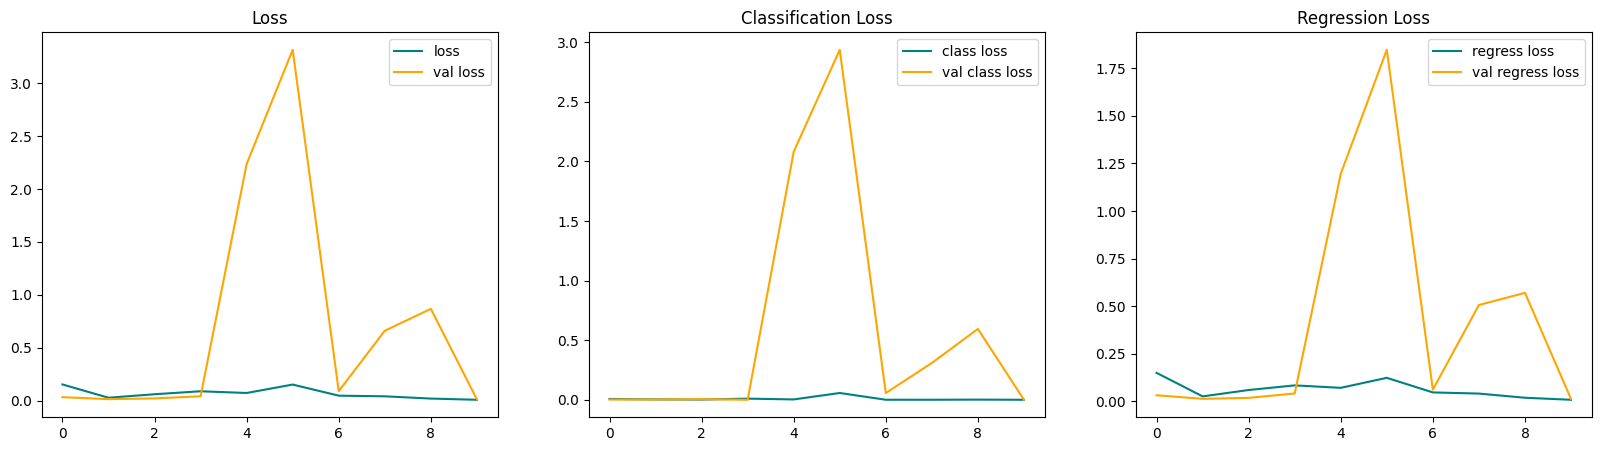

In [83]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Make Predictions

## Make Predictions on Test Set

In [87]:
test_data = test.as_numpy_iterator()

In [88]:
test_sample = test_data.next()

In [95]:
yhat = model.predict(test_sample[0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


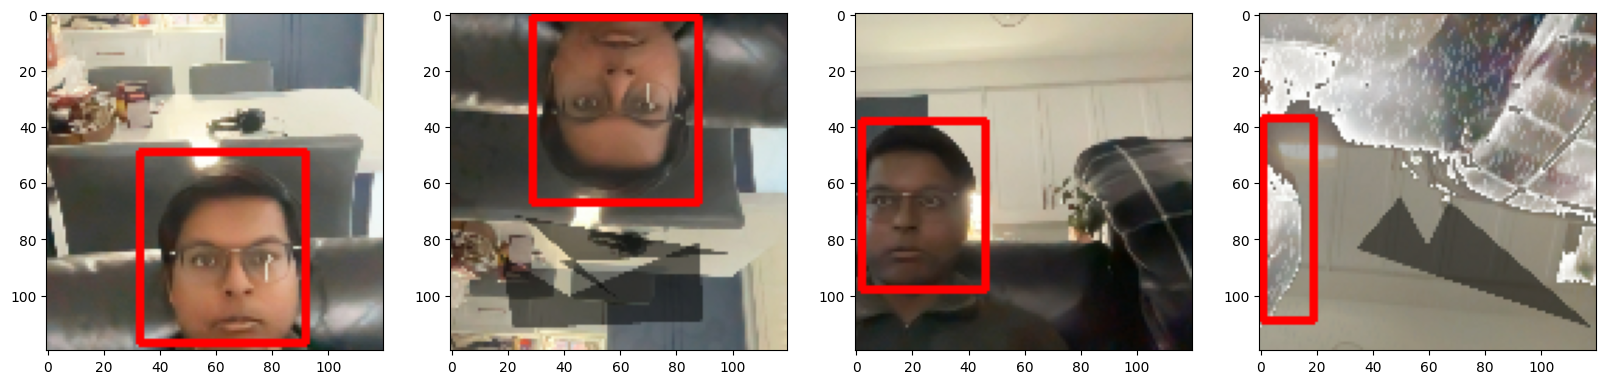

In [99]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Save Model

In [2]:
from tensorflow.keras.models import load_model

In [103]:
facetracker.save('facetracker.keras')

In [3]:
facetracker = load_model('facetracker.keras')

## Real Time Detection

In [4]:
import cv2
import numpy as np
import tensorflow as tf

cap = cv2.VideoCapture(1)

# Set camera resolution to 1080p
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

while cap.isOpened():
    _, frame = cap.read()
    
    # Adjust the cropping area (you can change these values based on your needs)
    frame = frame[100:1000, 400:1400, :]  # Adjust to a 600x900 region
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5:
        # Controls the main rectangle, adjusted for a larger cropped frame
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [900, 900]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [900, 900]).astype(int)), 
                      (255, 0, 0), 2)
        
        # Controls the label rectangle, adjusted for larger frame
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [900, 900]).astype(int), [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [900, 900]).astype(int), [80, 0])), 
                      (255, 0, 0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', 
                    tuple(np.add(np.multiply(sample_coords[:2], [900, 900]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



2024-10-22 00:41:27.711109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-10-22 00:41:28.034 Python[47846:1439108] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

: 